# DCGANs Pytorch implementation

## Generative Adversarial Network (GAN)
GANs are a framework for teaching a deep learning models to learn the training data's distribution so that it can generate new data with the same distribution.

They were invented by Ian Goodfellow in 2014, described in the paper [Generative Adversarial Nets](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf). They are made up of two  distinct models, a *generator* and a *discriminator*. Where the job of the generator is to create 'fake' images that look like the training data, whilst the discriminators job is to look at the generated image and output whether or not is a real training image or a fake image. During the training phase, the generator is constantly trying to outsmart the discrimintator and produce better and better fakes, while the discriminator is working to be come a better detective and correctly classify the real and fake images. The equilibrium to this game is when the generatror is generating perfect fakes that look as if they have came directly from the training data, whilst the discriminator is left to always guess at 50% confidence that the generator output is real or fake. 

### Notation

#### Discriminator Notation
*x* = data representing an image, it can be real or fake.
*D(x)* = discriminator network (i.e. function) which outputs a probability that *x* came from the training data rather than the generator. The function *D(x)8 can be thought of a traditional *binary classifier* such that *D(x)* should be HIGH i.e. 1 when *x* is real, and LOW i.e. 0 when *x* is fake.

#### Generator Notation
*z* = latent space vector sampled from a standard normal distribution, where the latent space is a representation of compressed data
*G(x)* = generator network (i.e. function) which maps the latent vector *z* to data-space. 

**Finsh understanding this from papers**

## Deep Convolutional Generatiev Adversarial Network (DCGAN)
Direct extension of the GAN described above, except that it explicitly uses convolutional and convolutional-transpose layers in the discriminator and generator, respectively. **What are convolution and convolutional-transpose layers?**

Described by Radford et. al. in the paper [Unsupervised Representation Learning With Deep Convolutional Generative Advarsarial Networks](https://arxiv.org/pdf/1511.06434.pdf). The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The inout is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution.
The generator is comprised of convolutional-transpose layers, batch norm layers, and ReLU activation. The input is a latent vector *z* that is drawn from a standard normal distribution and the putput is a 3x64x64 RGB image. The strided conv-transpose layers allow the latent vector to be transformed into a volume with the same shape as an image 

**Understand this more**


In [2]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchvision import models
from IPython.display import HTML
import time

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

# Seed() method used to initialise a random number generator
# The random number generator requires a number to start with (seed value) to be able to generate a random number
# If you the same seed value you'll get the same set of random numbers
random.seed(manualSeed)

# Sets the seed for randomly generating values with pytorch
torch.manual_seed(manualSeed)

Random Seed:  999


## Define inputs

**dataroot** - path to the root of the dataset folder. Needs to have sub directories in the dataset's root folder for ImageFolder to work.
**workers** - number of worker threads for loading the data with the DataLoader
**batch_size** - the batch size used in training, where the batch size refers to number of data points used in each round of training. The DCGAN paper uses a batch size of 128
**image_size** - the spatial size of the images used for training. All images will be resized to this size using a transformer. It is set to a default of 64x64, if another size is desired, the structures of D and G must be changed. See [here](https://github.com/pytorch/examples/issues/70) for details.
**nc** - number of color channels in the input images. For color images this is 3
**nz** - size of z latent vector (i.e. size of generator input)
**ngf** - relates to the depth of feature maps carried through the generator
**ndf** - sets the depth of feature maps propagated through the discriminator
**num_epochs** - number of training epochs to run. Training for longer will probably lead to beter results but will also take much longer

**lr** - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
**beta1** - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
**ngpu** - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs.

In [5]:
### Dataroots for the different datasets
home_dir = "/home/a/Projects/dggan-pytorch-2d-images/" # on machine
home_dir = "/media/a/Seagate Basic/home/a/Projects/dggan-pytorch-2d-images/" # on external hard drive

## Celeba Dataset: 
# dataset_name = "celeba"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/celeba/"

## Scan The World main dataset:
# dataset_name = "scan-the-world-main-images"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-main-images/"

## 2D Scan The World busts dataset: 
# dataset_name = "scan-the-world-busts-images"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/scan-the-world-busts-images/"

## Mixed god dataset:
# dataset_name = "mixed-gods"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/mixed-gods/"

# Sanitised mixed god dataset
# dataset_name = "sanitised-mixed-gods"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/sanitised-mixed-gods/"

# Sanitised mixed god dataset
# dataset_name = "sanitised-mixed-gods-scan-the-world"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/sanitised-mixed-gods-scan-the-world/"

# Unsanitised full dataset
# dataset_name = "unsanitised-full-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/all-scan-the-world-images/"

# # Facial recognition full dataset
# dataset_name = "facerecog-recog-full-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/facerecog-all-scan-the-world/"

# Tags classifier - busts
# dataset_name = "tags-classifier-fullbody"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/busts-tags-classifier/"
    
# Tags classifier - fullbody
# dataset_name = "tags-classifier-fullbody-seed-1312"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/fullbody-tags-classifier/"

# Fully manually sanitised fullbody dataset
# dataset_name = "fully-manually-sanitised-fullbody-dataset"
# dataroot = "/home/a/Projects/dggan-pytorch-2d-images/data/fully-manually-sanitised-fullbody-dataset/"

# Fully manually sanitised busts dataset
dataset_name = "fully-manually-sanitised-busts-dataset"
dataroot = home_dir + "data/fully-manually-sanitised-busts-dataset/"

workers = 2 
batch_size = 128
image_size = 64 
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [6]:
# Make output directory
results_dir = "results_" + dataset_name + "_epochs_" + str(num_epochs) + "_" + time.strftime("%Y%m%d-%H%M%S")
path = os.path.join(home_dir + "outputs", results_dir)
os.mkdir(path)

# Prepare the dataset

We begin by loading in the dataset using *ImageFolder* which is aa pytorch method to help with transforming datasets. 
It takes as parameters the root to the dataset directory as well as a transform, which is a function which describes the transformation that need to be performed on the original image
In this case it takes each image and resizes to the given *image_size*, then crops the given image at the center, converts it to a tensor and then normalises it
**TODO whta is a tensor, why normalise**

Then we create a dataloader for the dataset, where a dataloader is a class that helps to parallelize the data loading process with the support of automatic batching as well. We need this as if we were to load in the large datasets into memory all at once we would get memory outages and slowing down of programs.

**Add parameters properly to all of these**

Then set the device we want to train the models on. This will be set to the first GPU i.e. "cuda:0" if pytorch can detect a cuda-enable device and ngpu is greater than 0, else it will run it on the CPU. Note it is considerably faster to run on GPU.

Finally plot some of the transformed dataset points before any training has begun
**Understand matlab plotting better**

Size of the dataset:  21279


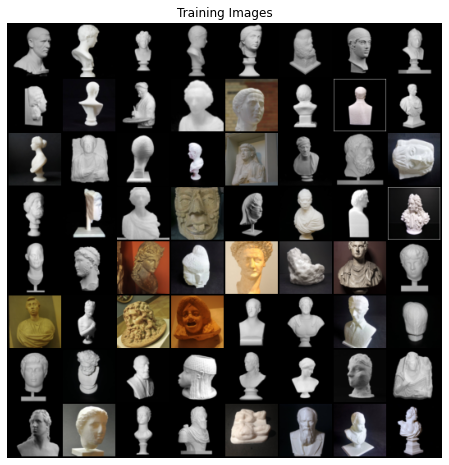

In [7]:
# Create dataset by standardising and normalizing the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Create the dataloader - python iterable over the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

dataset_size = len(dataloader.dataset)
print("Size of the dataset: ", dataset_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images before any training has begun
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Implementation
All functions to be defined
- Weight initialization strategy
- Generator 
- Discriminator
- Loss functions
- Training loop

# Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialiseed from a normal distribution with mean=0, stdev=0.02. The *weight_init* function takes an initialised model as input and reinitalises all convolutional, convolutional-transpose, and batch normalisation layers to meet this criteria. This function is applied to the models immediately after initialisation

**TODO: understand the __class__.name__ syntak amd why we have the line nn.init.constant_(m.bias.data, 0)**

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Define the generator class
The generator, *G*, is designed to map the latent space vector (z) to data-space. Since our data are images, converting *z* to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of [−1,1]. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training.

**TODO understand convolutional networks and what strided convolutional tranpose, batch norm and relu activation do**

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images).

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4          
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            
            
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create generator instance and apply weights_init function

Now, we can instantiate the generator and apply the weights_init function. Check out the printed model to see how the generator object is structured.

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Define the discrimintator class
As mentioned, the discriminator, *D*, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both G and D.

**TODO Consider adding a few more layers**

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
        
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Create discriminator instance and apply weights_init function

Now, we can instantiate the discriminator and apply the weights_init function. Check out the printed model to see how the discrimintator object is structured.

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Define Loss functions and Optimizers
With D and G setup, we can specify how they learn through the loss functions and optimizers. We will use the Binary Cross Entropy loss (BCELoss) function.

**TODO understand the loss function better here**
Notice how this function provides the calculation of both log components in the objective function (i.e. log(D(x)) and log(1−D(G(z)))). We can specify what part of the BCE equation to use with the y input. This is accomplished in the training loop which is coming up soon, but it is important to understand how we can choose which component we wish to calculate just by changing y (i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These labels will be used when calculating the losses of D and G, and this is also the convention used in the original GAN paper. Finally, we set up two separate optimizers, one for D and one for G. As specified in the DCGAN paper, both are Adam optimizers with learning rate 0.0002 and Beta1 = 0.5. For keeping track of the generator’s learning progression, we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution (i.e. fixed_noise) . In the training loop, we will periodically input this fixed_noise into G, and over the iterations we will see images form out of the noise.

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training loop
Finally, now that we have all of the parts of the GAN framework defined, we can train it. Be mindful that training GANs is somewhat of an art form, as incorrect hyperparameter settings lead to mode collapse with little explanation of what went wrong. Here, we will closely follow Algorithm 1 from Goodfellow’s paper, while abiding by some of the best practices shown in ganhacks. Namely, we will “construct different mini-batches for real and fake” images, and also adjust G’s objective function to maximize logD(G(z)). Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.

Part 1 - Train the Discriminator

Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. In terms of Goodfellow, we wish to “update the discriminator by ascending its stochastic gradient”. Practically, we want to maximize log(D(x))+log(1−D(G(z))). Due to the separate mini-batch suggestion from ganhacks, we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss (log(D(x))), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss (log(1−D(G(z)))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

Part 2 - Train the Generator

As stated in the original paper, we want to train the Generator by minimizing log(1−D(G(z))) in an effort to generate better fakes. As mentioned, this was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize log(D(G(z))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step. It may seem counter-intuitive to use the real labels as GT labels for the loss function, but this allows us to use the log(x) part of the BCELoss (rather than the log(1−x) part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training. The training statistics reported are:

Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches (log(D(x))+log(D(G(z)))).
Loss_G - generator loss calculated as log(D(G(z)))
D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better. Think about why this is.
D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better. Think about why this is.
Note: This step might take a while, depending on how many epochs you run and if you removed some data from the dataset.

**TODO read this section over again**

In [14]:
import csv
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_fake_losses = []
D_real_losses = []
D_x_acc = []
D_G_z1_acc = []
D_G_z2_acc = []
iters = 0

wtr = csv.writer(open (os.path.join(path,'training_stats.csv'), 'w', newline=''))
wtr.writerow(["Current Epoch", "Total number of epochs", "Iteration", "Batch_size", "D_losses", "D_fake_losses", "D_real_losses", "G_losses", "D_accuracy", "D_G_z1_accurancy", "D_G_z2_accuracy"])
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output - note this is loss on fake 
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_D_fake: %.4f\tLoss_D_real: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errD_fake.item(), errD_real.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            wtr.writerow([epoch, num_epochs, i, len(dataloader), errD.item(), errD_fake.item(), errD_real.item(), errG.item(), D_x, D_G_z1, D_G_z2])

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_fake_losses.append(errD_fake.item())
        D_real_losses.append(errD_real.item())
        D_x_acc.append(D_x)
        D_G_z1_acc.append(D_G_z1)
        D_G_z2_acc.append(D_G_z2)
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/167]	Loss_D: 1.9086	Loss_D_fake: 1.0868	Loss_D_real: 0.8217	Loss_G: 3.6934	D(x): 0.4878	D(G(z)): 0.6054 / 0.0359


KeyboardInterrupt: 

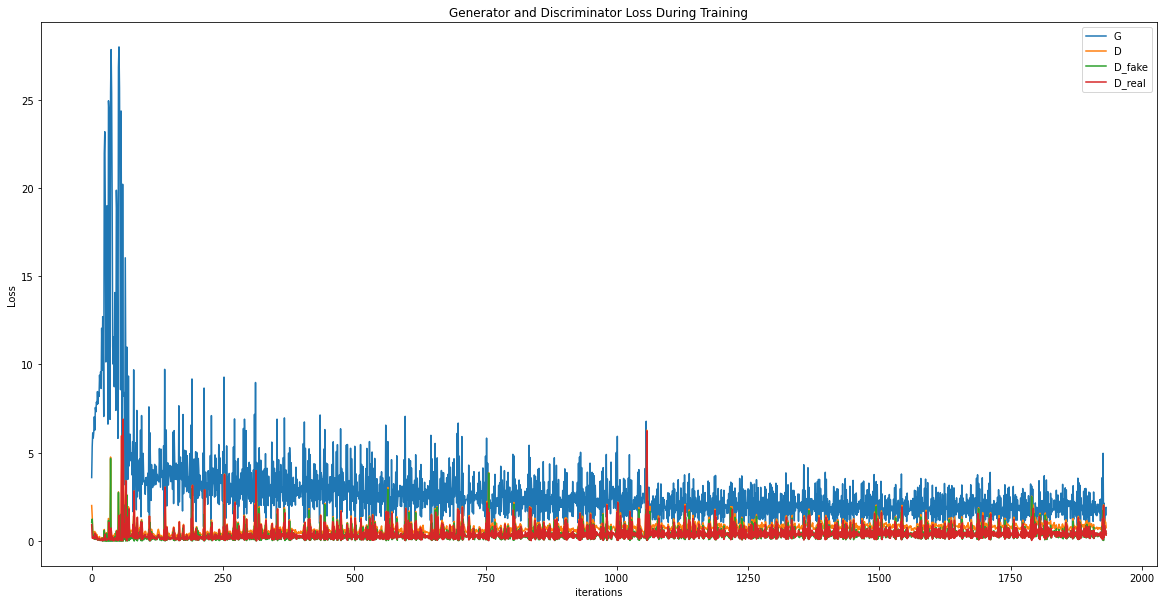

In [12]:
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(D_fake_losses,label="D_fake")
plt.plot(D_real_losses,label="D_real")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(path,"generator_discriminator_losses.png"))

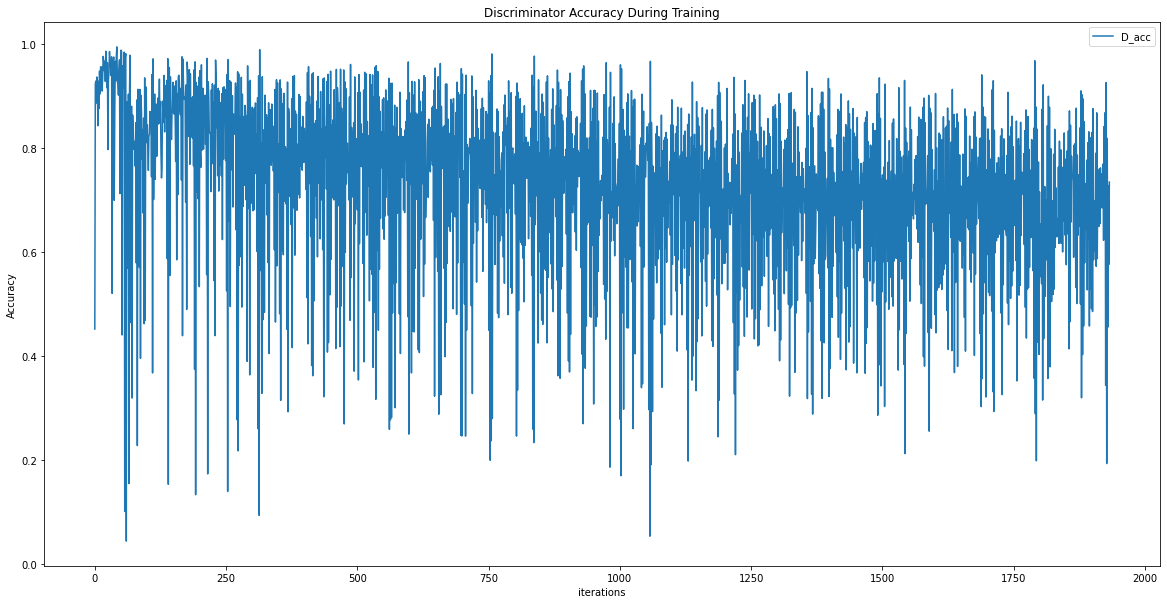

In [13]:
plt.figure(figsize=(20,10))
plt.title("Discriminator Accuracy During Training")
plt.plot(D_x_acc,label="D_acc")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(path,"discriminator_accuracy.png"))

In [14]:
from scipy import stats


d_losses_mode = stats.mode(D_losses)
d_fake_losses_mode = stats.mode(D_fake_losses)
d_real_losses_mode = stats.mode(D_real_losses)
g_losses_mode = stats.mode(G_losses)

f = open(os.path.join(path,"overall_stats.txt"), "a")
f.write("Dataset: \t" + dataset_name +"\n")
f.write("Dataset size: \t" + str(dataset_size) +"\n")
f.write("D_losses mean: \t" + str(np.mean(D_losses)) +"\n")
f.write("D_losses mode: \t" + str(d_losses_mode.mode[0]) +"\n")
f.write("D_fake_losses mean: \t" + str(np.mean(D_fake_losses)) +"\n")
f.write("D_fake_losses mode: \t" + str(d_fake_losses_mode.mode[0]) +"\n")
f.write("D_real_losses mean: \t" + str(np.mean(D_real_losses)) +"\n")
f.write("D_real_losses mode: \t" + str(d_real_losses_mode.mode[0]) +"\n")
f.write("G_losses mean: \t" + str(np.mean(G_losses)) +"\n")
f.write("G_losses mode: \t" + str(g_losses_mode.mode[0]) +"\n")
f.write("Discriminator accuracy mean \t" + str(np.mean(D_x_acc)))

f.close()

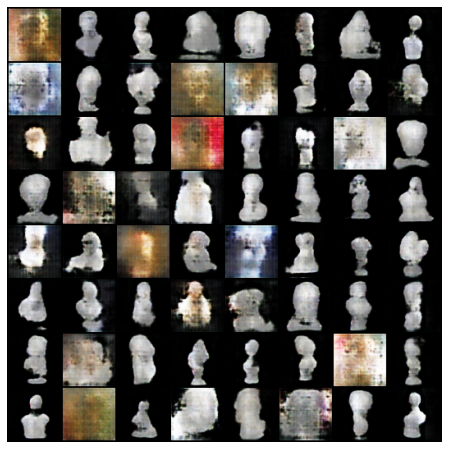

In [15]:
# Animation of generations over time

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

RuntimeError: CUDA error: unspecified launch failure

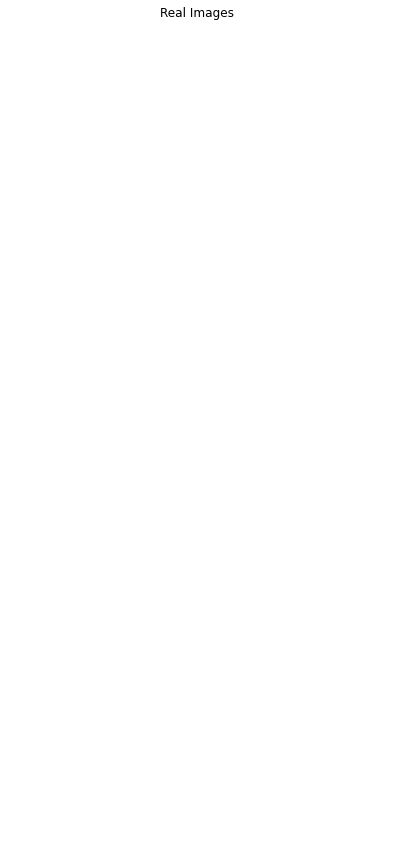

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.savefig(os.path.join(path,"real_vs_fake_images.png"))

In [ ]:
from torchvision.utils import save_image

gen_img_dir = os.path.join(path, "generated_images")
if not os.path.exists(gen_img_dir):
    os.mkdir(gen_img_dir)
im_batch_size = 64
n_images=100
for i_batch in range(0, n_images, im_batch_size):
    gen_images = netG(fixed_noise)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join(gen_img_dir, f'image_{i_batch+i_image:05d}.png'))

In [ ]:
from zipfile import ZipFile
from os.path import basename


zip_file = "/home/a/Projects/dggan-pytorch-2d-images/outputs/" + results_dir + ".zip"
with ZipFile(zip_file, 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk(path):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath, basename(filePath))